# 'Data Science 4 Covid19': analysis of testing dataset

### UC Sistemas Inteligentes para a Bioinformática 20 | 21

Group 4: 
> Carina Afonso PG40952 <br>
> Laura Duro PG40959 <br>
> Miguel Rocha PG40967 <br> 
> Miguel Martins PG40969 <br>

## 1. Work contextualization and data description

The Covid19 pandemic has been widely studied across several fields due to its large scale effects globally. More than 1.5 million people have died due to health complications caused by SARS-CoV-2 infection, since the final months of 2019. 

To figth this pandemic countries have been deploying different aproaches, namely testing policies. In this effort, we propose to analyse and explore the official testing data available for different countries. We aim to relate this information (tests wise) with other variables (demographic descriptors and pandemic related information) trough computacional methods such as machine and deep learning.

The data chosen for this work was retrieved from 'Our World in Data': https://ourworldindata.org/coronavirus-testing [1]. It comprises of a time series, updated around twice a week, with mostly numeric data from official sources from 111 countries.

## 2. Data preprocessing

### 2.1. Libraries required

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl

### 2.2 Data import

In [2]:
#import dataset - covid-19 testing data
data_imported = pd.read_csv('owid-covid-data.csv')

### 2.2 Inicial data screening

In [3]:
print('Shape:\t', data_imported.shape, '\n')
print('Columns:', data_imported.columns.values, '\n')

Shape:	 (55703, 52) 

Columns: ['iso_code' 'continent' 'location' 'date' 'total_cases' 'new_cases'
 'new_cases_smoothed' 'total_deaths' 'new_deaths' 'new_deaths_smoothed'
 'total_cases_per_million' 'new_cases_per_million'
 'new_cases_smoothed_per_million' 'total_deaths_per_million'
 'new_deaths_per_million' 'new_deaths_smoothed_per_million'
 'reproduction_rate' 'icu_patients' 'icu_patients_per_million'
 'hosp_patients' 'hosp_patients_per_million' 'weekly_icu_admissions'
 'weekly_icu_admissions_per_million' 'weekly_hosp_admissions'
 'weekly_hosp_admissions_per_million' 'new_tests' 'total_tests'
 'total_tests_per_thousand' 'new_tests_per_thousand' 'new_tests_smoothed'
 'new_tests_smoothed_per_thousand' 'positive_rate' 'tests_per_case'
 'tests_units' 'total_vaccinations' 'total_vaccinations_per_hundred'
 'stringency_index' 'population' 'population_density' 'median_age'
 'aged_65_older' 'aged_70_older' 'gdp_per_capita' 'extreme_poverty'
 'cardiovasc_death_rate' 'diabetes_prevalence' 'femal

Trough the analysis of the presented variables in the dataset, we decided to remove the ones that presented no interest to the proposed task (testing analysis).

In [4]:
#drop columns with no interest
data_imported.columns
data_imported = data_imported.drop(columns = ['cardiovasc_death_rate', 
                                              'diabetes_prevalence', 
                                              'female_smokers',
                                              'male_smokers',
                                              'total_vaccinations',
                                              'total_vaccinations_per_hundred'])

print('Shape:\t', data_imported.shape, '\n')

Shape:	 (55703, 46) 



In [5]:
#type of data per variable of interest
data_imported.dtypes

iso_code                               object
continent                              object
location                               object
date                                   object
total_cases                           float64
new_cases                             float64
new_cases_smoothed                    float64
total_deaths                          float64
new_deaths                            float64
new_deaths_smoothed                   float64
total_cases_per_million               float64
new_cases_per_million                 float64
new_cases_smoothed_per_million        float64
total_deaths_per_million              float64
new_deaths_per_million                float64
new_deaths_smoothed_per_million       float64
reproduction_rate                     float64
icu_patients                          float64
icu_patients_per_million              float64
hosp_patients                         float64
hosp_patients_per_million             float64
weekly_icu_admissions             

#### 2.2.1 Tests_units (variable)

Different countries might have different methods of registering data and/or reported their data in different formats.

In [6]:
#see test units
print('Number of entries per test type:')
print(data_imported.groupby(['tests_units']).size(), '\n\n')

#frequency table per countries
freq_table = pd.crosstab(index = data_imported['tests_units'], columns = data_imported['iso_code'])
print('Entries distribution per countries:\n')
print(freq_table, '\n\n')
print('Number of countries per test type:')
print((freq_table/freq_table).sum(axis = 1), '\n')
print('Total of countries:', ((freq_table/freq_table).sum(axis = 1)).sum(), '\n\n')

#check for missing values
null = data_imported.iloc[:, 33].isnull().sum()
na = data_imported.iloc[:, 33].isna().sum()
print('Missing values')
print('Null:', null, '\tNaN:', na, '\n')

Number of entries per test type:
tests_units
people tested       6415
samples tested      4929
tests performed    18146
units unclear        626
dtype: int64 


Entries distribution per countries:

iso_code         ARE  ARG  AUS  AUT  BEL  BGD  BGR  BHR  BLR  BOL  ...  TUR  \
tests_units                                                        ...        
people tested      0  320    0    0    0    0    0    0    0    0  ...    0   
samples tested     0    0    0    0    0    0    0    0    0    0  ...    0   
tests performed  329    0  276  265  296  295  256    0  266  283  ...  271   
units unclear      0    0    0    0    0    0    0  293    0    0  ...    0   

iso_code         TWN  UGA  UKR  URY  USA  VNM  ZAF  ZMB  ZWE  
tests_units                                                   
people tested    342    0    0    0    0    0  320    0    0  
samples tested     0  189    0    0    0  157    0    0    0  
tests performed    0    0  258  270  294    0    0  279  230  
units unclea

After seeing how countries are distributed based on the tests_units variable we decided to use only data from dataset entries which reported the number of tests and not the number of people tested. We also decided to discard dataset entries without defined units.

We also checked for missing values (wich in this case correspond to null values).

Since the data was also registered at an Internacional and Worldlide level in this dataset, we decided to discard these entries as they compreend an compilation of data from several crountries.

In [7]:
#drop Nan
data_imported = data_imported.dropna(subset = ['tests_units'])

print('Missing values')
na = data_imported.iloc[:, 33].isna().sum()
print('NaN:', na, '\n\n')


#drop countries with odd units
countries_discard = pd.concat(objs = (freq_table.loc['units unclear'][freq_table.loc['units unclear'][:] != 0], 
                                      freq_table.loc['people tested'][freq_table.loc['people tested'][:] != 0]))
countries_discard.keys()

#discard internacional data
index_discard = np.concatenate([data_imported['location'][data_imported['location'] == 'International'].keys().values,
                                data_imported['location'][data_imported['location'] == 'World'].keys().values])
#discard countries without standardized testing
for code in countries_discard.keys().values:
    index_discard = np.concatenate([index_discard,
                                    data_imported['iso_code'][data_imported['iso_code'] == code].keys().values])

screened_data = data_imported.drop(index = index_discard)
    
#frequency table per countries
freq_table = pd.crosstab(index = screened_data['tests_units'], columns = screened_data['iso_code'])
print('Number of countries per test type:')
print((freq_table/freq_table).sum(axis = 1), '\n')
print('Total of countries:', ((freq_table/freq_table).sum(axis = 1)).sum(), '\n\n')

Missing values
NaN: 0 


Number of countries per test type:
tests_units
samples tested     19.0
tests performed    69.0
dtype: float64 

Total of countries: 88.0 




In total, 88 countries reported testing data in a similar way and further analysis will be conducted for these countries (we will be considering the number of tests performed / samples tested, not the number of people tested).

#### 2.2.2 Other testing variables

In [8]:
#NaN 
#screened_data['total_cases']

print('Null:')
null = screened_data.iloc[:, 4:32].isnull().sum()
print(null, '\n')
print('Total:\t', null.sum(), '\n\n')
print('NaN:')
na = screened_data.iloc[:, 4:32].isna().sum()
print(na, '\n')
print('Total:\t', na.sum(), '\n\n')

screened_data.iloc[:, 4:32] = screened_data.iloc[:, 4:32].fillna(0)

print('NaN:')
na = screened_data.iloc[:, 4:32].isna().sum()
print(na, '\n')
print('Total:\t', na.sum(), '\n\n')

Null:
total_cases                             358
new_cases                               359
new_cases_smoothed                      506
total_deaths                           1664
new_deaths                             1664
new_deaths_smoothed                     506
total_cases_per_million                 358
new_cases_per_million                   359
new_cases_smoothed_per_million          506
total_deaths_per_million               1664
new_deaths_per_million                 1664
new_deaths_smoothed_per_million         506
reproduction_rate                      3234
icu_patients                          18287
icu_patients_per_million              18287
hosp_patients                         18130
hosp_patients_per_million             18130
weekly_icu_admissions                 22684
weekly_icu_admissions_per_million     22684
weekly_hosp_admissions                22446
weekly_hosp_admissions_per_million    22446
new_tests                              3472
total_tests               

Substitution of missing values of these pandemic related variables with 0 (when reported as a missing value, in these variables, it means there was no information on that entry regarding that variable).

In [9]:
screened_data.iloc[:, 32:].isna().sum()

tests_per_case                 2396
tests_units                       0
stringency_index                772
population                        0
population_density              117
median_age                        0
aged_65_older                     0
aged_70_older                     0
gdp_per_capita                  275
extreme_poverty                5246
handwashing_facilities        14072
hospital_beds_per_thousand     2431
life_expectancy                   0
human_development_index           0
dtype: int64

In [10]:
print(screened_data.shape)
screened_data = screened_data.drop(columns = ['handwashing_facilities'])
screened_data = screened_data.dropna(axis = 0)
print(screened_data.shape)

(23075, 46)
(14223, 45)


The drop of the column 'handwashing_facilities' was due to lack of information regarding a considerable amount of countries (over 14 000 entries).
To deal with the other missing values, intead of dropping the columns in question we decided to drop the entries. In theses cases, we could not replace missing values with 0 because these variables do not represent counts but demographic indicators with their own scale and values associated.

In [11]:
 screened_data['iso_code'].unique().size

57

Further filtering of the data reduced the number of countries to a total of 57.

### 2.3 Statistical Analysis

In [12]:
screened_data.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,hospital_beds_per_thousand,life_expectancy,human_development_index
count,1.422300e+04,14223.000000,14223.000000,14223.000000,14223.000000,14223.000000,14223.000000,14223.000000,14223.000000,14223.000000,...,1.422300e+04,14223.000000,14223.000000,14223.000000,14223.000000,14223.000000,14223.000000,14223.000000,14223.000000,14223.000000
mean,2.027076e+05,2368.141320,2317.595397,5755.277227,46.582578,46.056820,4986.785806,66.954789,65.034587,142.379943,...,6.117230e+07,172.071099,33.599114,11.492790,7.511982,22035.417972,8.841468,3.120093,75.131415,0.759530
std,8.137200e+05,10916.039656,8775.866896,16522.687567,140.750421,135.566421,8074.031390,170.521598,133.524539,228.320761,...,1.915158e+08,263.143701,9.158794,6.542922,4.617631,18483.770730,17.515572,2.261857,6.375523,0.138216
min,1.000000e+00,-10034.000000,0.143000,0.000000,-1918.000000,-232.143000,0.018000,-214.609000,0.001000,0.000000,...,3.412500e+05,3.202000,16.400000,2.168000,1.308000,1095.042000,0.100000,0.200000,61.040000,0.463000
25%,2.443000e+03,17.000000,22.000000,46.000000,0.000000,0.286000,279.133000,2.035000,2.554000,4.645500,...,6.948445e+06,43.951000,26.500000,5.732000,3.212000,6426.674000,0.200000,1.300000,70.780000,0.640000
50%,1.746600e+04,212.000000,224.571000,364.000000,3.000000,3.571000,1503.831000,13.847000,14.797000,30.856000,...,1.838396e+07,93.105000,34.100000,11.087000,6.890000,20551.409000,1.300000,2.540000,76.680000,0.798000
75%,1.260135e+05,1253.500000,1309.000000,2926.000000,23.000000,23.286000,5899.138000,61.307500,63.101000,164.511500,...,5.088288e+07,205.859000,42.300000,18.571000,11.976000,30155.152000,6.400000,4.485000,81.320000,0.871000
max,1.614322e+07,823225.000000,213297.143000,297904.000000,2354.000000,2383.143000,65106.330000,9760.898000,1719.769000,1568.473000,...,1.380004e+09,1454.037000,47.900000,23.021000,16.240000,94277.965000,77.600000,8.800000,83.560000,0.939000


Above there are descriptive analysis made for each of the selected variables.

Text(0, 0.5, 'Share of the Population (%)')

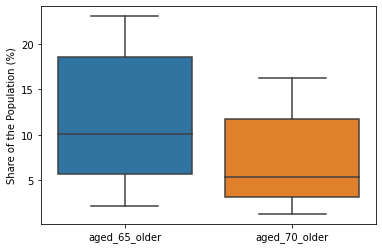

In [13]:
fig, axes = plt.subplots(1, 1, sharex = True)
sns.boxplot(data = screened_data[['iso_code', 'aged_65_older','aged_70_older']].drop_duplicates(subset=['iso_code']))
axes.set_ylabel('Share of the Population (%)')

In the figure above we can see the percentage of the population over 65 years old (yo) and over 70 yo. In some countries, the percentage reaches above 10% of the population which could be of importance considering that people in this age are considered part of the groups at risk.

Text(0, 0.5, 'Age (years)')

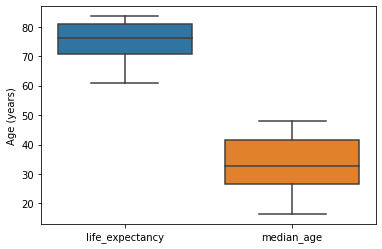

In [14]:
fig, axes = plt.subplots(1, 1, sharex = True)
sns.boxplot(data = screened_data[['iso_code', 'life_expectancy', 'median_age']].drop_duplicates(subset=['iso_code']))
axes.set_ylabel('Age (years)')

Regarding 'life_expectancy', as seen in the figure above, there's an interval between the ages of 70 and 80 which comprises around 50% of the countries' life expectancy values.
The median age for the 57 countries considered shows that possibly all types of countries (under developped, in development and developed) are present - median age is one of the development indicators. [2-3]

Text(0, 0.5, 'HDI')

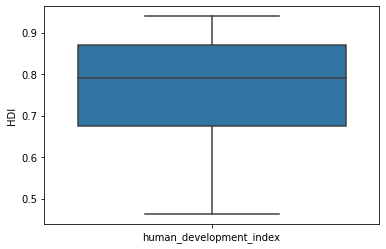

In [15]:
fig, axes = plt.subplots(1, 1, sharex = True)
sns.boxplot(data = screened_data[['iso_code', 'human_development_index']].drop_duplicates(subset=['iso_code']))
axes.set_ylabel('HDI')

According to the 'Human Development Report 2020: Reader's Guide', by United Nations Development Programme, 'HDI classifications are based on HDI fixed cutoff points, which are derived from the quartiles of dis- tributions of the component indicators. The cutoff-points are HDI of less than 0.550 for low human development, 0.550–0.699 for medium human development, 0.700–0.799 for high human development and 0.800 or greater for very high human development.'

In the figure above we can perceive that about 25% of the countries considered low to medium human development.

Text(0, 0.5, 'Positive rate')

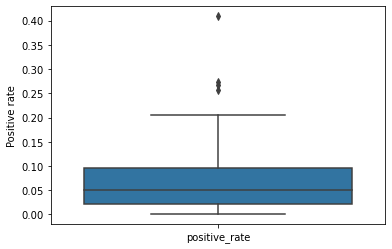

In [16]:
fig, axes = plt.subplots(1, 1, sharex = True)
sns.boxplot(data = screened_data[['iso_code','positive_rate']].drop_duplicates(subset=['iso_code']))
axes.set_ylabel('Positive rate')

The positive rates (ratio between positive tests and tests performed), for 50% of the countries selected, is below 5%. There are some countries who present an alarming value for positve rates.

#### 2.3.1 Time series dataset preparation

In [17]:
print('Type of data for date information:')
print(screened_data['date'].dtypes)
screened_data['date'] = pd.to_datetime(screened_data['date']) 
print('\nType of data for date information after conversion:')
print(screened_data['date'].dtypes)
print('\nShape of dataset:')
print(screened_data.shape)
screened_data = screened_data.set_index('date')
print('\nShape of dataset after indexing:')
print(screened_data.shape)


Type of data for date information:
object

Type of data for date information after conversion:
datetime64[ns]

Shape of dataset:
(14223, 45)

Shape of dataset after indexing:
(14223, 44)


In [18]:
screened_data.columns

Index(['iso_code', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'hospi

In [19]:
pca_data = screened_data[['new_cases_smoothed', 'new_deaths_smoothed', 'total_cases_per_million',
                          'new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 
                          'icu_patients_per_million', 'hosp_patients_per_million', 'weekly_icu_admissions_per_million',
                          'weekly_hosp_admissions_per_million', 'total_tests_per_thousand', 
                          'positive_rate', 'tests_per_case', 'stringency_index',
                          'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 
                          'gdp_per_capita', 'extreme_poverty', 'hospital_beds_per_thousand', 'life_expectancy',
                          'human_development_index']]

In [20]:
'new_tests_smoothed_per_thousand'

'new_tests_smoothed_per_thousand'

#### 2.3.2 Clustering and PCA

In [21]:
from sklearn.decomposition import PCA # for PCA calculation

In [22]:
pca = PCA()
X_pca = pca.fit(pca_data)

Text(0, 0.5, 'cumulative explained variance')

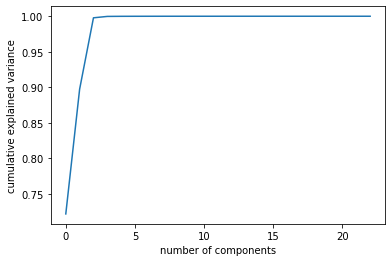

In [23]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [24]:
num_components = 3
pca = PCA(num_components)  
X_pca = pca.fit_transform(pca_data) # fit and reduce dimension

In [25]:
pd.DataFrame(pca.components_, columns = pca_data.columns)

,new_cases_smoothed,new_deaths_smoothed,total_cases_per_million,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,...,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,hospital_beds_per_thousand,life_expectancy,human_development_index
0,0.005144,0.000304,0.170266,0.002384,0.000033,0.000002,0.000254,0.001633,0.000036,0.000072,...,-0.000190,-0.000078,3.222747e-04,0.000230,0.000159,0.985359,-0.000463,0.000052,0.000266,6.119271e-06
1,0.882257,0.010929,0.462813,0.007236,0.000096,-0.000005,0.000321,0.002324,0.000090,0.000214,...,0.000231,0.001353,-5.909145e-07,-0.000021,-0.000015,-0.084630,-0.000047,-0.000014,0.000007,1.022674e-07
2,0.470567,0.005112,-0.869711,-0.008408,-0.000157,0.000012,-0.000397,-0.002898,-0.000228,-0.000350,...,-0.000180,0.001622,7.515788e-05,0.000039,0.000024,0.147909,0.000098,0.000004,-0.000042,-9.545903e-08


In [26]:
pca = PCA(n_components = 0.99)
X_pca = pca.fit_transform(pca_data) # this will fit and reduce dimensions
print(pca.n_components_)

3


In [27]:
n_pcs= pca.n_components_ # get number of component# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = pca_data.columns
# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

In [28]:
most_important_names

['gdp_per_capita', 'new_cases_smoothed', 'total_cases_per_million']

In [29]:
from sklearn.cluster import KMeans

print('new_tests_smoothed_per_thousand')

new_tests_smoothed_per_thousand


In [30]:
kmean_data = screened_data[['new_cases_smoothed', 'new_deaths_smoothed', 'total_cases_per_million',
                          'new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 
                          'icu_patients_per_million', 'hosp_patients_per_million', 'weekly_icu_admissions_per_million',
                          'weekly_hosp_admissions_per_million', 'total_tests_per_thousand', 
                          'positive_rate', 'tests_per_case', 'stringency_index',
                          'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 
                          'gdp_per_capita', 'extreme_poverty', 'hospital_beds_per_thousand', 'life_expectancy',
                          'human_development_index']]

In [31]:
kmeans = KMeans(n_clusters = 5)
kmeans.fit(kmean_data)

KMeans(n_clusters=5)

In [32]:
kmeans.labels_

array([0, 0, 0, ..., 1, 1, 1])

In [33]:
k = 4
kmeans = KMeans(n_clusters = k, max_iter = 1000)
kmeans.fit(kmean_data)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

pd.crosstab(labels, screened_data['new_tests_smoothed_per_thousand'], rownames=['clusters'] )

new_tests_smoothed_per_thousand,0.000,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,...,18.034,18.132,18.202,18.259,18.357,18.371,18.627,18.673,18.710,19.287
clusters,,,,,,,,,,,,,,,,,,,,,
0,2,0,0,0,0,0,0,2,1,2,...,0,0,0,0,0,0,0,0,0,0
1,30,75,63,40,44,53,43,39,19,26,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,2,1,0,1,0,...,1,1,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
from tslearn.clustering import TimeSeriesKMeans
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
model.fit(kmean_data)

TimeSeriesKMeans(max_iter=10, metric='dtw')

In [39]:
labels = model.labels_
pd.crosstab(labels, screened_data['new_tests_smoothed_per_thousand'], rownames=['clusters'] )

new_tests_smoothed_per_thousand,0.000,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,...,18.034,18.132,18.202,18.259,18.357,18.371,18.627,18.673,18.710,19.287
clusters,,,,,,,,,,,,,,,,,,,,,
0,30,75,63,40,44,53,43,39,19,26,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,1,0,2,1,0,1,0,...,1,1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,2,1,2,...,0,0,0,0,0,0,0,0,0,0


### 2.4 Model training

#### 2.4.1 Dataset Preparation

In [ ]:
model_data = screened_data[['total_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths_smoothed',
                            'total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 
                            'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 
                            'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 
                            'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
                            'weekly_hosp_admissions_per_million', 'positive_rate', 'tests_per_case',  
                            'stringency_index', 'population', 'population_density', 'median_age', 'aged_65_older',
                            'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'life_expectancy', 'human_development_index']]
                            


In [ ]:
#'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand',      


#stringency_index, gdp_per_capita, extreme_poverty, population_density, tests_per_case -> retirar linhas nulas aquando treino modelos

## References

    [1]  Hasell, J., Mathieu, E., Beltekian, D. et al. A cross-country database of COVID-19 testing. Sci Data 7, 345 (2020)
    [2]  Hannah Ritchie (2019) - "Age Structure". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/age-structure' [Online Resource]
    [3] UN. (2017). Changing population age structures and sustainable development. Department of Economic and Social Affairs, ST/ESA/SER(E/CN.9/2017/2), 33.